<a href="https://colab.research.google.com/github/dreamer0710/StillWork_Team_5/blob/main/team_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

팀 프로젝트를 위한 노트북입니다. 이하 문제정의서 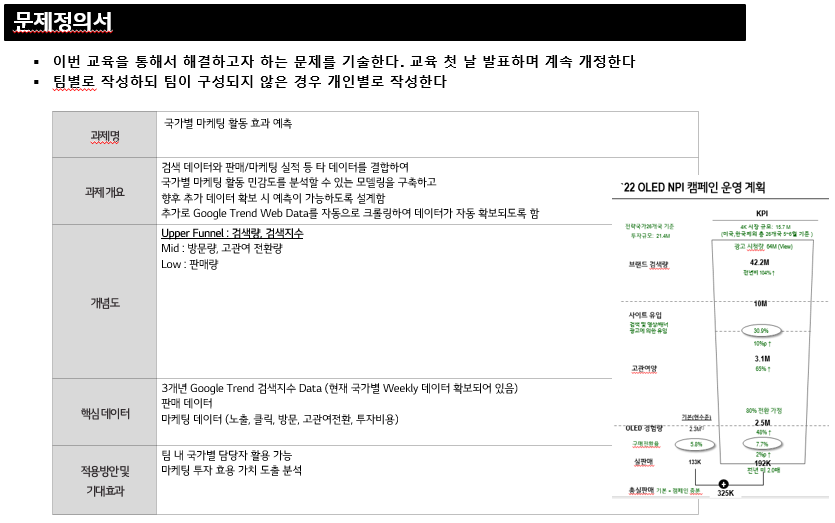

**2/16일 교육 시간에 논의된 내용**

5조 요약
- 국가단위로 보면 데이터 충분하지 않다.
- 국가별 마케팅 했을 때, 검색량, 판매 set out의 민감도 해보자
- 향후에 투자를 계속 이어갈 수 있을 거니까, 

목적 데이터 :
검색 지수, 판매
랜덤포레스트 쓰면 됨
1 hot 인코딩
입력변수는 다양하게 잘 골라야 한다.
국가는 그룹핑(클러스터링), 성격이 비슷한 국가를 묶어야함.
선진국/후진국, or 10개정도 클러스터링, 비 많이 오는 국가/ 아닌국가

# 과제 (WIP)
* 필요한 틀을 잡는 상황입니다. 수행되지 않아요 (2/17일)

## Import

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8,6)
matplotlib.rcParams.update({'font.size': 14})

In [4]:
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC, SVR
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error,r2_score               
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_validate

## 코랩에 한글 폰트 설치
- (주의!) 아래 셀을 한 번 실행 후에, 런타임 - 런타임 다시 시작을 실행하고 아래 셀을 한번 더 실행하여야 한다

In [23]:
# import matplotlib as mpl
# import matplotlib.pyplot as plt
# import matplotlib.font_manager as fm
 
# !apt -qq -y install fonts-nanum
 
# fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
# font = fm.FontProperties(fname=fontpath, size=10)
# plt.rc('font', family='NanumBarunGothic') 
# mpl.font_manager._rebuild()

fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


### 한글 설정

In [5]:
import platform, matplotlib
from matplotlib import rc

matplotlib.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Windows':
    rc('font', family="Malgun Gothic")
elif platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Linux':
    rc('font', family='NanumBarunGothic')

## 테이타 파일을 읽기

In [6]:
# CSV 파일은 utf-8 기준으로 저장되어야 한글이 정상적으로 처리됩니다.
data = pd.read_csv('https://github.com/dreamer0710/StillWork_Team_5/raw/main/Team_5_data.csv')
print(data.shape)
print(data.head())
print(data.keys())
data.info()

(9736, 37)
   YEAR  MONTH  Q   Region         법인  ... QLED LG OLED SONY OLED  OLED  4K
0  2019      1  1  Oceania  Australia  ...  8.0     7.0       1.0  19.0  76
1  2019      1  1  Oceania  Australia  ...  4.0     4.0       2.0  12.0  52
2  2019      1  1  Oceania  Australia  ...  4.0     6.0       1.0  15.0  58
3  2019      1  1  Oceania  Australia  ...  5.0     4.0       0.5  10.0  56
4  2019      2  1  Oceania  Australia  ...  4.0     4.0       0.5   8.0  56

[5 rows x 37 columns]
Index(['YEAR', 'MONTH', 'Q', 'Region', '법인', 'COUNTRY', '성숙도', '기간1', '기간2',
       '미디어', '미디어2', 'Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM',
       'Spending(M$)_Digital', 'WTB_Seeding', 'WTB_SEM', ' WTB ',
       ' OLED 검색량 TTL ', ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ',
       ' Seeding WTB Upper+Mid ', ' Seeding WTB Low ', ' SEM WTB Brand+Core ',
       ' SEM WTB Low ', 'Comp_campaign', 'TVC_GRP', 'Spending(M$)_TVC',
       'GRP_High BM', 'Comp_GRP', ' Sell-out ', 'selout_remarks', 'Week',
     

### 데이타 조정하기

*   국가(country) 그룹핑이 필요

참고: [d_23_Clusters.ipynb](https://colab.research.google.com/github/StillWork/HE_0216/blob/main/d_23_Clusters.ipynb#scrollTo=301baf6b)

In [7]:
df = data.copy() # 원본 복사에서 사용함
print(df.shape)


(9736, 37)


#### ' - ' 를 0으로 전환하기  
['Spending(M$)\n_Seeding'],	'Spending(M$)\n_SEM',	'Spending(M$)_Digital',	'WTB_Seeding',	'WTB_SEM',	'WTB' 열은 

In [9]:
#for index, row in df.iterrows():
#  print("'%s'" % row["Spending(M$)\n_Seeding"])
#print(f'"df['Spending(M$)\n_Seeding']")
#print(df[['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital']])
df[['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital']] = df[['Spending(M$)\n_Seeding','Spending(M$)\n_SEM', 'Spending(M$)_Digital']].replace(' - ',0.0)

df['Spending(M$)\n_Seeding'] = df['Spending(M$)\n_Seeding'].apply(lambda x: float(''.join(x.split(',')) if type(x) == str else x ))
#for index, row in df.iterrows():
#  print("'%s'" % row["Spending(M$)\n_Seeding"], type(row["Spending(M$)\n_Seeding"]))
#df['Spending(M$)\n_SEM'] = df['Spending(M$)\n_SEM'].astype(float)
df['Spending(M$)_Digital'] = df['Spending(M$)_Digital'].astype(float)
print (df['Spending(M$)\n_Seeding'][df['Spending(M$)\n_Seeding'].isnull()])
#df[['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital']]
#print(df[['WTB_Seeding', 'WTB_SEM', ' WTB ']])
df[['WTB_Seeding', 'WTB_SEM', ' WTB ']] = df[['WTB_Seeding', 'WTB_SEM', ' WTB ']].replace(' - ',0)
#df[['WTB_Seeding', 'WTB_SEM', ' WTB ']]
#print (df['WTB_SEM'][df['WTB_SEM'].isnull()])

df['WTB_Seeding'] = df['WTB_Seeding'].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
df['WTB_SEM'] = df['WTB_SEM'].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
df[' WTB '] = df[' WTB '].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
#print (df[' WTB '][df[' WTB '].isnull()])

#print(df[' Sell-out '].dtypes)
#df[' Sell-out '] = df[' Sell-out '].apply(lambda x: print(x, type(x)))
#df[' Sell-out '] = df[' Sell-out '].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))
#df[' Sell-out '] = df[' Sell-out '].astype(int)
#for index, row in df.iterrows():
#  if type(row["WTB_Seeding"]) != str and row["WTB_Seeding"] != 0:  
#    print("'%s'" % row["WTB_Seeding"])

Series([], Name: Spending(M$)\n_Seeding, dtype: float64)


#### Z(TVC_GRP)가 AB(GRP_High_BM)보다 높으면 2, Z에 숫자는 있지만 AB보다 작으면 1, Z에 숫자가 없으면 0 으로 데이터 치환한다 -> 1-hot 인코,

In [10]:
#for index, row in df.iterrows():
#  print("'%s'" % row['TVC_GRP'])
df['TVC_GRP'] = df.loc[:, ('TVC_GRP', 'GRP_High BM')].apply(lambda x: 0 if x[0] == 'nan' else 2 if x[0] > x[1] else 1, axis=1) 
#for index, row in df.iterrows():
#  print("'%s'" % row['TVC_GRP'])

#### '기간1' 내용이 없는 데이타는 버린다.

In [11]:
df2 = df[df['기간1'].notnull()]
print(df2.shape)
df2 = df2[df2[' Sell-out '].notnull()]
print(df2.shape)


df2[' Sell-out '] = df2[' Sell-out '].apply(lambda x: int(''.join(x.split(',')) if type(x) == str else x ))

(8236, 37)
(7743, 37)


#### 성숙도와 기간1은 1 hot 인코딩을 한다.

In [12]:
df2['성숙도'].value_counts()
df2['기간1'].value_counts()
df2 = pd.get_dummies(df2, columns=["성숙도","기간1"])
df2[:3]

,YEAR,MONTH,Q,Region,법인,COUNTRY,기간2,미디어,미디어2,Spending(M$)\n_Seeding,Spending(M$)\n_SEM,Spending(M$)_Digital,WTB_Seeding,WTB_SEM,WTB,OLED 검색량 TTL,LG OLED 검색량 TTL,LG OLED 검색량 Low,Seeding WTB Upper+Mid,Seeding WTB Low,SEM WTB Brand+Core,SEM WTB Low,Comp_campaign,TVC_GRP,Spending(M$)_TVC,GRP_High BM,Comp_GRP,Sell-out,selout_remarks,Week,QLED,LG OLED,SONY OLED,OLED,4K,성숙도_미성숙,성숙도_성숙,성숙도_성숙진입,기간1_캠페인,기간1_캠페인+1w,기간1_캠페인+2w,기간1_캠페인+3w,기간1_캠페인이전,기간1_캠페인이후
0,2019,1,1,Oceania,Australia,Australia,캠페인이전,No media,No,0.0,0.0,0.0,0,0,0,-,-,-,-,-,-,-,NaN,1,NaN,NaN,NaN,1802,NaN,2019-01-06,8.0,7.0,1.0,19.0,76,0,1,0,0,0,0,0,1,0
1,2019,1,1,Oceania,Australia,Australia,캠페인이전,No media,No,0.0,0.0,0.0,0,0,0,-,-,-,-,-,-,-,NaN,1,NaN,NaN,NaN,1147,NaN,2019-01-13,4.0,4.0,2.0,12.0,52,0,1,0,0,0,0,0,1,0
2,2019,1,1,Oceania,Australia,Australia,캠페인이전,No media,No,0.0,0.0,0.0,0,0,0,-,-,-,-,-,-,-,NaN,1,NaN,NaN,NaN,1383,NaN,2019-01-20,4.0,6.0,1.0,15.0,58,0,1,0,0,0,0,0,1,0


#### 'OLED카테고리지수', 'OLED경쟁지수' 열을 구성합니다.


*   분모라 0인 경우가 있어서 분자 분모에 최소값(0.1)을 더해서 처리합니다.



In [13]:
df2.loc[:,'OLED경쟁지수'] = df2.loc[:, ('LG OLED', 'QLED')].apply(lambda x: (x[0]+0.1) / (x[1]+0.1), axis=1)
print(df2['OLED경쟁지수'])
df2.loc[:,'OLED카테고리지수'] = df2.loc[:, ('OLED', '4K')].apply(lambda x: (x[0]+0.1) / (x[1]+0.1), axis=1)
print(df2['OLED카테고리지수'])
print(df2.keys())

0       0.876543
1       1.000000
2       1.487805
3       0.803922
4       1.000000
          ...   
9730    1.000000
9731    1.000000
9732    0.024390
9733    1.000000
9734    1.000000
Name: OLED경쟁지수, Length: 7743, dtype: float64
0       0.250986
1       0.232246
2       0.259897
3       0.180036
4       0.144385
          ...   
9730    0.002849
9731    0.092971
9732    0.002169
9733    0.078695
9734    0.092971
Name: OLED카테고리지수, Length: 7743, dtype: float64
Index(['YEAR', 'MONTH', 'Q', 'Region', '법인', 'COUNTRY', '기간2', '미디어', '미디어2',
       'Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital',
       'WTB_Seeding', 'WTB_SEM', ' WTB ', ' OLED 검색량 TTL ',
       ' LG OLED 검색량 TTL ', ' LG OLED 검색량 Low ', ' Seeding WTB Upper+Mid ',
       ' Seeding WTB Low ', ' SEM WTB Brand+Core ', ' SEM WTB Low ',
       'Comp_campaign', 'TVC_GRP', 'Spending(M$)_TVC', 'GRP_High BM',
       'Comp_GRP', ' Sell-out ', 'selout_remarks', 'Week', 'QLED', 'LG OLED',
       'SONY OLED', 'OLE

#### X값과 Y값을 정의합니다.

In [14]:
x_keys = ['Spending(M$)\n_Seeding', 'Spending(M$)\n_SEM', 'Spending(M$)_Digital', 'WTB_Seeding', 'WTB_SEM', ' WTB ' , 'TVC_GRP', '성숙도_미성숙',
       '성숙도_성숙', '성숙도_성숙진입', '기간1_캠페인', '기간1_캠페인+1w', '기간1_캠페인+2w',
       '기간1_캠페인+3w', '기간1_캠페인이전', '기간1_캠페인이후']
y_keys = [' Sell-out ']

df3 = df2[x_keys]
print(df3.info)
print(df3.describe())

#y = df2[y_keys]
y = df2[' Sell-out ']
X_train, X_test, y_train, y_test = train_test_split(df3, y)
print(X_train.shape, X_test.shape, y_train.shape,y_test.shape)

print(y.dtypes)

#np.where(np.isnan(X_train))
#np.where(np.isnan(y_train))

<bound method DataFrame.info of       Spending(M$)\n_Seeding Spending(M$)\n_SEM  ...  기간1_캠페인이전  기간1_캠페인이후
0                        0.0                0.0  ...          1          0
1                        0.0                0.0  ...          1          0
2                        0.0                0.0  ...          1          0
3                        0.0                0.0  ...          1          0
4                        0.0                0.0  ...          1          0
...                      ...                ...  ...        ...        ...
9730                     0.0              0.001  ...          1          0
9731                     0.0              0.001  ...          1          0
9732                     0.0                0.0  ...          1          0
9733                     0.0                0.0  ...          1          0
9734                     0.0                0.0  ...          1          0

[7743 rows x 16 columns]>
       Spending(M$)\n_Seeding  Spending(M

## Random Forest Regressor 로 학습시키기

In [15]:
def show_reg_result(y_test,y_pred):
    print(y_test[:3])
    print(y_pred[:3])
    print(np.abs(y_test - y_pred))
    print("Max Error: ", 
      round(np.abs(y_test - y_pred).max(),5))
    print("Mean Absolute Error: ", 
      round(np.abs(y_test-y_pred).mean(),5))
    print("Root Mean Squared Error: ", 
      mean_squared_error(y_test,y_pred, squared=False).round(5))
    print("R-Squared: ", 
      r2_score(y_test, y_pred).round(5))

print(X_train.head)
print(y_train.head)

rfr = RandomForestRegressor()

rfr.fit(X_train, y_train)
#rfr.fit(X_train, y_train.values.ravel())

y_pred = rfr.predict(X_test)
#print(y_pred.shape, y_test.shape)
show_reg_result(y_test,y_pred)

<bound method NDFrame.head of       Spending(M$)\n_Seeding Spending(M$)\n_SEM  ...  기간1_캠페인이전  기간1_캠페인이후
7958                   0.000                0.0  ...          1          0
9457                   0.000                0.0  ...          1          0
7662                   0.000                0.0  ...          1          0
7326                   0.000                0.0  ...          1          0
5896                   0.000              0.001  ...          0          1
...                      ...                ...  ...        ...        ...
8655                   0.002              0.001  ...          0          0
5663                   0.000                0.0  ...          1          0
4891                   0.001              0.019  ...          0          0
9118                   0.000              0.001  ...          0          0
7397                   0.000              0.001  ...          1          0

[5807 rows x 16 columns]>
<bound method NDFrame.head of 7958     12
9

In [16]:
def cross_validation(model, X, y, n=5): 
    cv = KFold(n, shuffle=True)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

In [17]:
cross_validation(rfr,df3,y)

0.5196

In [18]:
def plot_feature_weight(feature, weight):
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

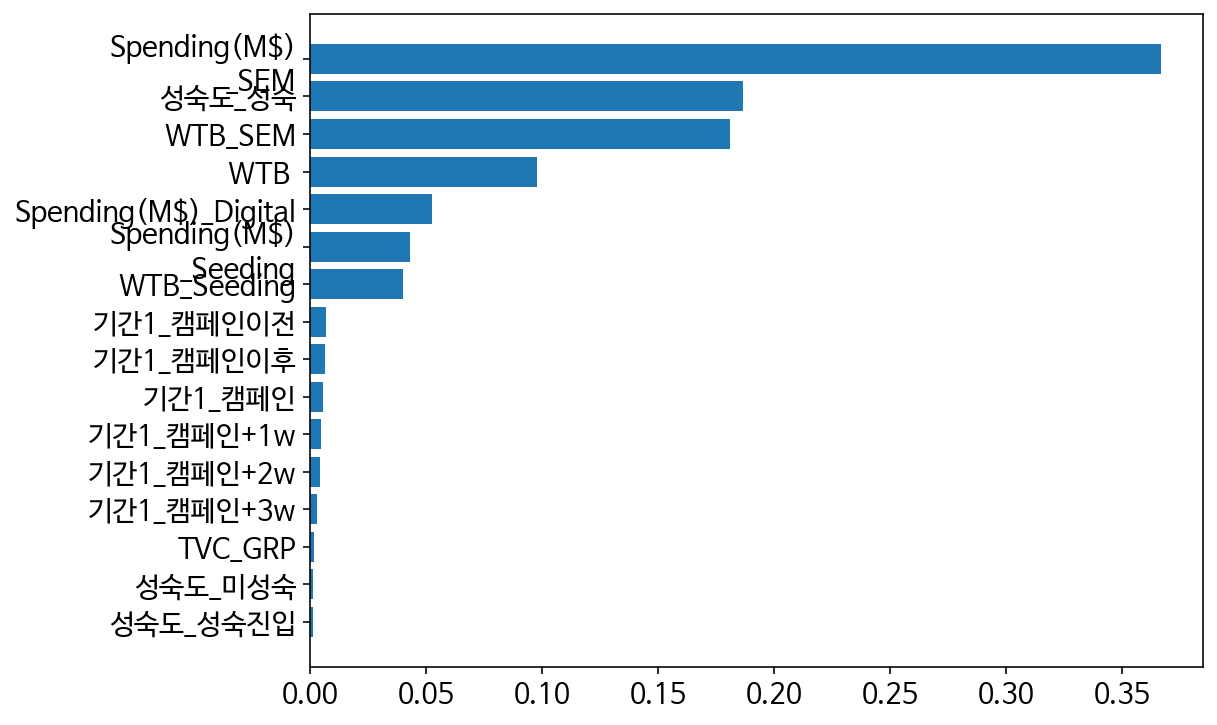

In [19]:
plot_feature_weight(df3.columns, rfr.feature_importances_)